<a href="https://colab.research.google.com/github/ApahSaroj/WQC/blob/main/LightGBM_WQC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install graphviz  

In [3]:
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
is_regression = False #set this True to run classification
plotTree = True #if you haven't installed graphviz set this to False

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_excel('/content/drive/MyDrive/DATA/WQC_test.xlsx')
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.drop(df.columns[df.columns.str.contains('WPI',case = False)],axis = 1, inplace = True)
df

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WQC
0,8.14,8.7,84.0,52.0,147.8,4.48,44.0,20.0,1.17,0.285,7.80,0.758000,6.534660,0.06211,Excellent
1,7.70,8.8,110.0,76.0,188.0,8.61,44.0,36.0,3.46,0.401,14.80,0.196062,8.138620,0.00960,Excellent
2,7.60,7.5,75.0,44.0,128.0,8.11,28.0,20.0,2.80,0.379,14.80,0.298875,3.855625,0.01280,Excellent
3,8.20,9.1,76.0,56.0,127.0,6.30,44.0,18.0,1.65,0.396,9.60,0.299590,2.238750,0.01536,Excellent
4,7.31,7.3,84.0,52.0,140.0,5.50,28.0,20.0,1.61,0.265,8.30,0.106000,5.600000,0.01000,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,7.60,5.6,224.0,8.0,370.0,16.14,92.0,24.0,7.60,2.270,23.04,1.352000,104.480000,0.01500,Excellent
483,7.30,5.6,266.0,96.0,434.0,20.56,96.0,32.0,9.89,1.550,30.86,7.074000,61.068000,0.03300,Excellent
484,5.10,5.8,290.0,12.0,487.0,37.35,60.0,44.0,14.80,0.159,60.13,9.256000,89.910000,0.16300,Excellent
485,7.40,6.4,230.0,72.0,385.0,20.06,70.0,42.0,10.35,1.360,32.92,7.110435,48.500000,0.21900,Good


In [7]:
dataset=df
dataset.head()

,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WQC
0,8.14,8.7,84.0,52.0,147.8,4.48,44.0,20.0,1.17,0.285,7.8,0.758000,6.534660,0.06211,Excellent
1,7.70,8.8,110.0,76.0,188.0,8.61,44.0,36.0,3.46,0.401,14.8,0.196062,8.138620,0.00960,Excellent
2,7.60,7.5,75.0,44.0,128.0,8.11,28.0,20.0,2.80,0.379,14.8,0.298875,3.855625,0.01280,Excellent
3,8.20,9.1,76.0,56.0,127.0,6.30,44.0,18.0,1.65,0.396,9.6,0.299590,2.238750,0.01536,Excellent
4,7.31,7.3,84.0,52.0,140.0,5.50,28.0,20.0,1.61,0.265,8.3,0.106000,5.600000,0.01000,Excellent


In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

features = []; categorical_features = []

num_of_rows = dataset.shape[0]
num_of_columns = dataset.shape[1]
num_of_classes = 1 #default value is 1 for regression. we will update this for classification.

for i in range(0, num_of_columns):
    column_name = dataset.columns[i]
    column_type = dataset[column_name].dtypes
    
    if i != num_of_columns - 1: #skip target
        features.append(column_name)
    
    if column_type == 'object':
        #encode with sklearn
        le.fit(dataset[column_name])
        feature_classes = list(le.classes_)
        #print(feature_classes)
        
        encoded_feature = le.transform(dataset[column_name])
        dataset[column_name] = pd.DataFrame(encoded_feature)
        
#encode with manually
        """feature_classes = dataset[column_name].unique()
        
        for j in range(len(feature_classes)):
            feature_class = feature_classes[j]
            print(feature_class," -> ",j,", ",end='')
                        
            dataset[column_name] = dataset[column_name].replace(feature_class, str(j))"""
        
        if i != num_of_columns - 1: #skip target
            categorical_features.append(column_name)
        
        if is_regression == False and i == num_of_columns - 1:
            num_of_classes = len(feature_classes)

In [9]:
print("num_of_classes: ",num_of_classes)
print("features: ",features)
print("categorical features: ",categorical_features)

num_of_classes:  4
features:  ['pH', 'DO', 'TDS', 'Alkalinity', 'EC', 'Na', 'Ca', 'Mg', 'K', 'F', 'Cl', 'Nitrate', 'Sulphate', 'Phosphate']
categorical features:  []


In [10]:
print("encoded dataset")
dataset.head()

encoded dataset


,pH,DO,TDS,Alkalinity,EC,Na,Ca,Mg,K,F,Cl,Nitrate,Sulphate,Phosphate,WQC
0,8.14,8.7,84.0,52.0,147.8,4.48,44.0,20.0,1.17,0.285,7.8,0.758000,6.534660,0.06211,0
1,7.70,8.8,110.0,76.0,188.0,8.61,44.0,36.0,3.46,0.401,14.8,0.196062,8.138620,0.00960,0
2,7.60,7.5,75.0,44.0,128.0,8.11,28.0,20.0,2.80,0.379,14.8,0.298875,3.855625,0.01280,0
3,8.20,9.1,76.0,56.0,127.0,6.30,44.0,18.0,1.65,0.396,9.6,0.299590,2.238750,0.01536,0
4,7.31,7.3,84.0,52.0,140.0,5.50,28.0,20.0,1.61,0.265,8.3,0.106000,5.600000,0.01000,0


In [11]:
target_name = dataset.columns[num_of_columns - 1] #target is the final column at the right on data set

y_train = dataset[target_name].values
x_train = dataset.drop(columns=[target_name]).values

print("input features:\n",x_train)
print("--------------------")
print("output:\n",y_train)

input features:
 [[8.1400000e+00 8.7000000e+00 8.4000000e+01 ... 7.5800000e-01
  6.5346600e+00 6.2110500e-02]
 [7.7000000e+00 8.8000000e+00 1.1000000e+02 ... 1.9606200e-01
  8.1386200e+00 9.6000000e-03]
 [7.6000000e+00 7.5000000e+00 7.5000000e+01 ... 2.9887500e-01
  3.8556250e+00 1.2800000e-02]
 ...
 [5.1000000e+00 5.8000000e+00 2.9000000e+02 ... 9.2560000e+00
  8.9910000e+01 1.6300000e-01]
 [7.4000000e+00 6.4000000e+00 2.3000000e+02 ... 7.1104355e+00
  4.8500000e+01 2.1900000e-01]
 [7.6000000e+00 6.9000000e+00 2.4300000e+02 ... 6.3850000e+00
  5.9940000e+01 7.0000000e-02]]
--------------------
output:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [12]:
lgb_train = lgb.Dataset(x_train, y_train
    ,feature_name = features
    , categorical_feature = categorical_features
)

In [13]:
params = {
    'task': 'train'
    , 'boosting_type': 'gbdt'
    , 'objective': 'regression' if is_regression == True else 'multiclass'
    , 'num_class': num_of_classes
    , 'metric': 'rmsle' if is_regression == True else 'multi_logloss'
    , 'min_data': 1
    #, 'learning_rate':0.1
    , 'verbose': -1
}

In [14]:
gbm = lgb.train(params, lgb_train, num_boost_round=50)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [15]:
predictions = gbm.predict(x_train)
print(predictions)

[[9.99622155e-01 2.50775401e-04 2.83577663e-05 9.87122404e-05]
 [9.99622155e-01 2.50775401e-04 2.83577663e-05 9.87122404e-05]
 [9.99622155e-01 2.50775401e-04 2.83577663e-05 9.87122404e-05]
 ...
 [9.99622154e-01 2.50776859e-04 2.83571094e-05 9.87122315e-05]
 [5.02432628e-03 9.94543587e-01 9.70751928e-05 3.35011759e-04]
 [9.99622155e-01 2.50775400e-04 2.83577324e-05 9.87122402e-05]]


In [16]:
for index, instance in dataset.iterrows():
    actual = instance[target_name]
    
    if is_regression == True:
        prediction = round(predictions[index])
    else: #classification
        prediction = np.argmax(predictions[index])
    
    print((index+1),". actual= ",actual,", prediction= ",prediction)

1 . actual=  0.0 , prediction=  0
2 . actual=  0.0 , prediction=  0
3 . actual=  0.0 , prediction=  0
4 . actual=  0.0 , prediction=  0
5 . actual=  0.0 , prediction=  0
6 . actual=  0.0 , prediction=  0
7 . actual=  0.0 , prediction=  0
8 . actual=  0.0 , prediction=  0
9 . actual=  0.0 , prediction=  0
10 . actual=  0.0 , prediction=  0
11 . actual=  0.0 , prediction=  0
12 . actual=  0.0 , prediction=  0
13 . actual=  0.0 , prediction=  0
14 . actual=  0.0 , prediction=  0
15 . actual=  1.0 , prediction=  1
16 . actual=  0.0 , prediction=  0
17 . actual=  0.0 , prediction=  0
18 . actual=  0.0 , prediction=  0
19 . actual=  0.0 , prediction=  0
20 . actual=  0.0 , prediction=  0
21 . actual=  0.0 , prediction=  0
22 . actual=  0.0 , prediction=  0
23 . actual=  0.0 , prediction=  0
24 . actual=  0.0 , prediction=  0
25 . actual=  0.0 , prediction=  0
26 . actual=  0.0 , prediction=  0
27 . actual=  0.0 , prediction=  0
28 . actual=  0.0 , prediction=  0
29 . actual=  0.0 , predictio

In [17]:
predictions_classes = []
for i in predictions:
    if is_regression == True:
        predictions_classes.append(round(i))
    else:
        predictions_classes.append(np.argmax(i))

predictions_classes = np.array(predictions_classes)

In [18]:
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
accuracy = accuracy_score(predictions_classes, y_train)*100
print(accuracy,"%")

100.0 %


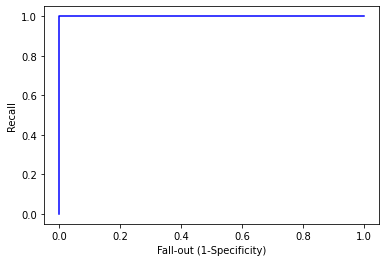

In [19]:
if is_regression == False:
    actuals_onehot = pd.get_dummies(y_train).values
    false_positive_rate, recall, thresholds = roc_curve(actuals_onehot[0], np.round(predictions)[0])
    roc_auc = auc(false_positive_rate, recall)
    
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')

    plt.show()

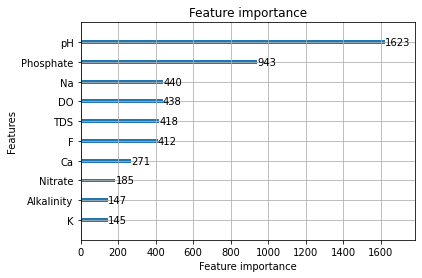

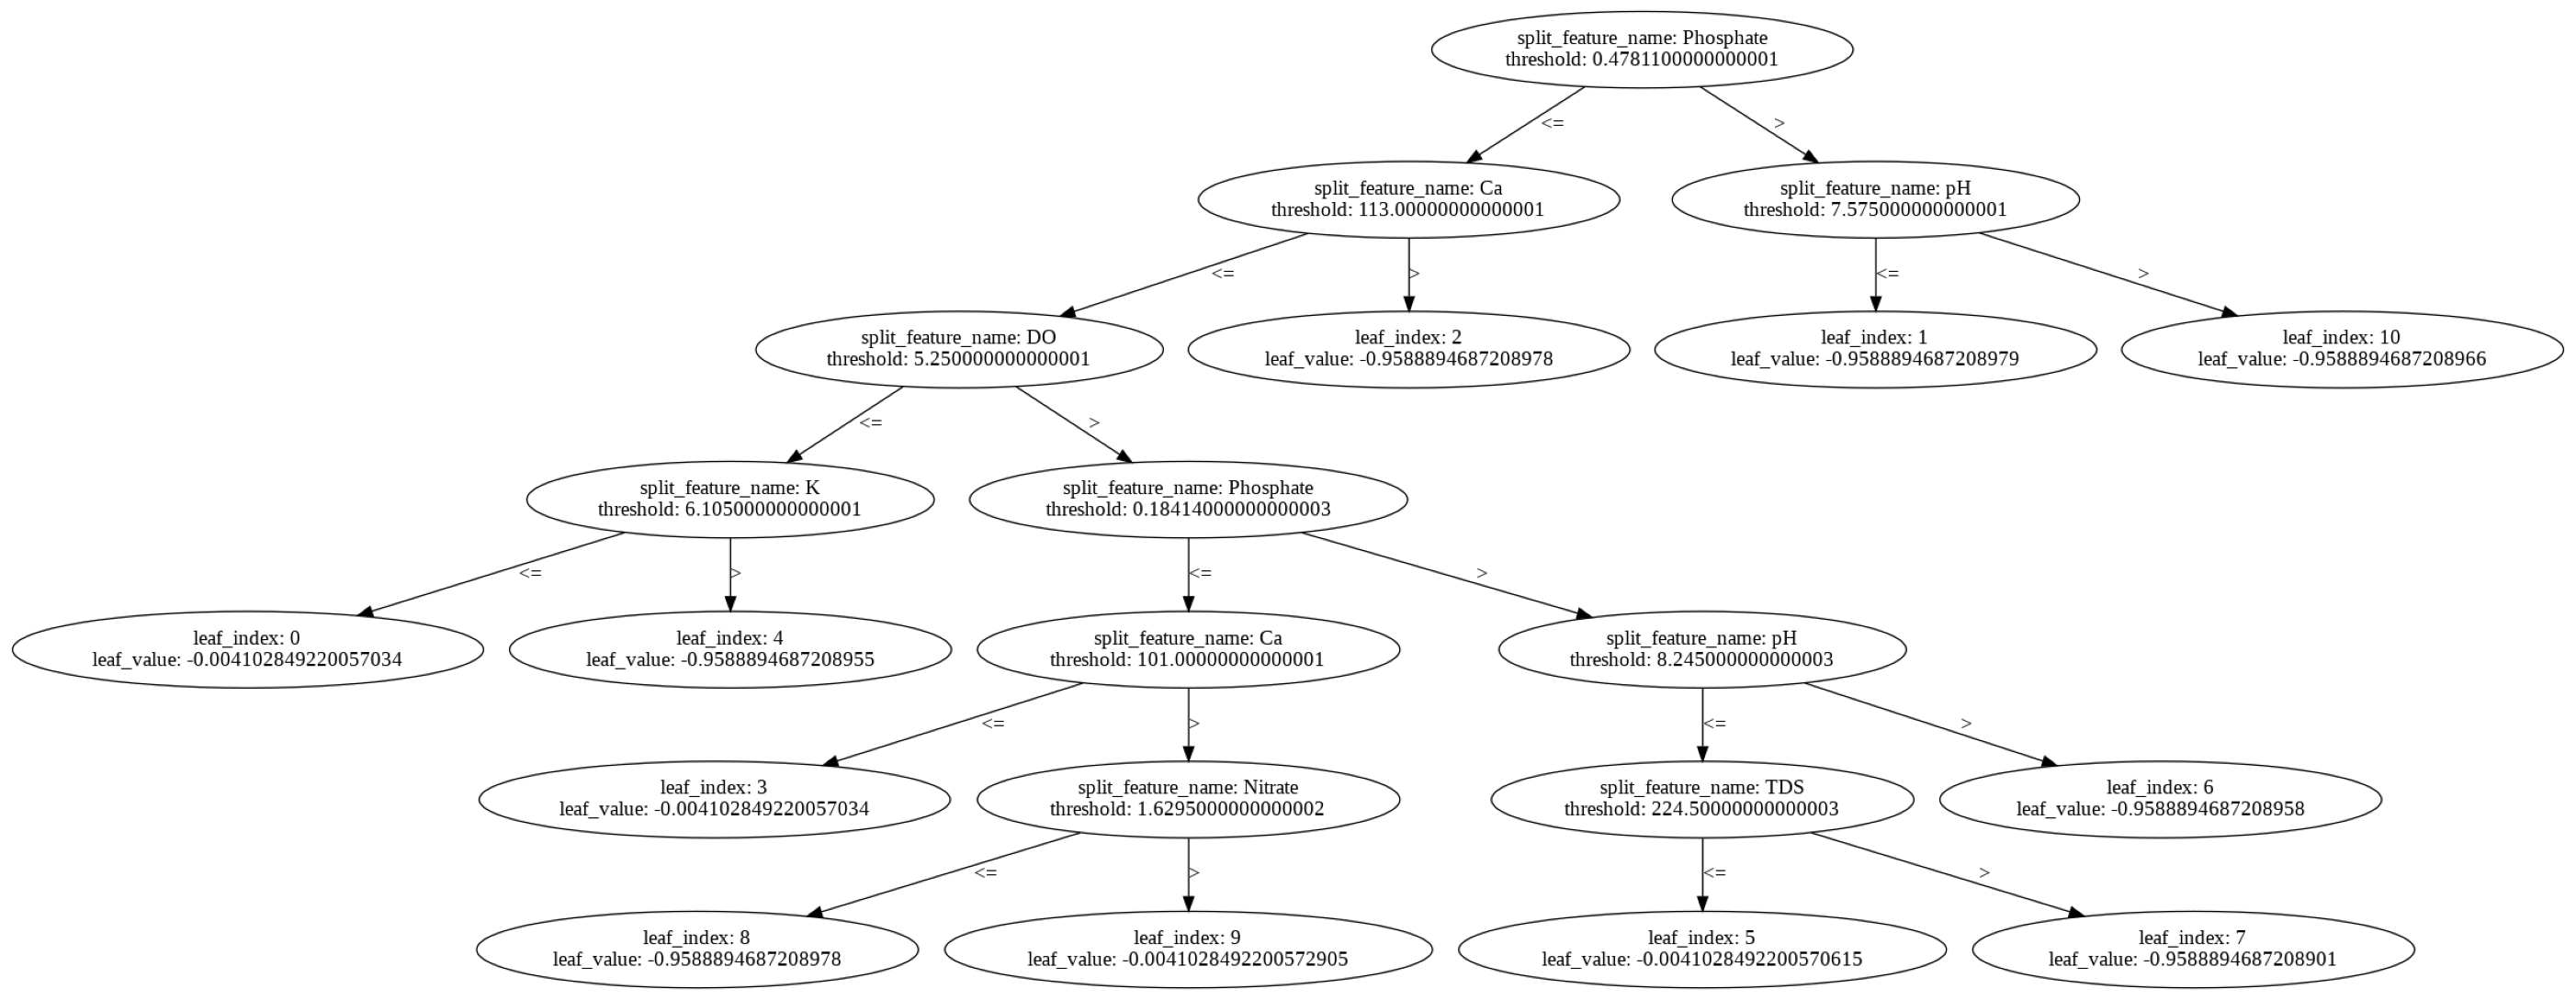

In [20]:
if plotTree == True:
    
    ax = lgb.plot_importance(gbm, max_num_features=10)
    plt.show()
    
    fig_size = [50, 30]
    plt.rcParams["figure.figsize"] = fig_size

    ax = lgb.plot_tree(gbm)
    plt.show()